In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import missingno as msn

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
df.drop(['SkinThickness', 'Insulin'],axis=1,inplace=True)

In [5]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [6]:
df['Glucose'] = df['Glucose'].apply(lambda x: df['Glucose'].mean() if x== 0 else x)

In [7]:
df['BloodPressure'] = df['BloodPressure'].apply(lambda x: df['BloodPressure'].mean() if x== 0 else x)

In [8]:
df['BMI'] = df['BMI'].apply(lambda x: df['BMI'].mean() if x== 0 else x)

<AxesSubplot:>

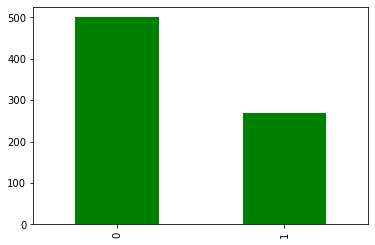

In [9]:
df['Outcome'].value_counts().plot(kind='bar',color='green')

In [10]:
y = df['Outcome']
X = df.drop('Outcome',axis=1)

In [11]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(1)
X_ns,y_ns=os.fit_sample(X,y)
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y_ns)))

The number of classes before fit Counter({0: 500, 1: 268})
The number of classes after fit Counter({1: 500, 0: 500})


C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=1 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


In [12]:
X = X_ns
y = y_ns

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=40)

In [14]:
from xgboost import XGBClassifier

In [15]:
xgb = XGBClassifier()

In [16]:
xgb.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [17]:
grid = {
    
    'max_depth':range(3,100),
 'min_child_weight':range(1,20),
 'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)],}
    

In [18]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [19]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0)

In [20]:
xgb_random.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=XGBClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'max_depth': range(3, 100),
                                        'min_child_weight': range(1, 20),
                                        'subsample': [0.6, 0.7, 0.8, 0.9]},
                   scoring='accuracy')

In [21]:
best_model = xgb_random.best_estimator_

In [22]:
best_model

XGBClassifier(colsample_bytree=0.7, gamma=0.3, max_depth=41, subsample=0.8)

In [23]:
xgb_random.best_params_

{'subsample': 0.8,
 'min_child_weight': 1,
 'max_depth': 41,
 'gamma': 0.3,
 'colsample_bytree': 0.7}

In [24]:
xgb_random.best_score_

0.832857142857143

In [25]:
y_pred = best_model.predict(X_test)

In [26]:
err  =(y_pred- y_test)

<AxesSubplot:>

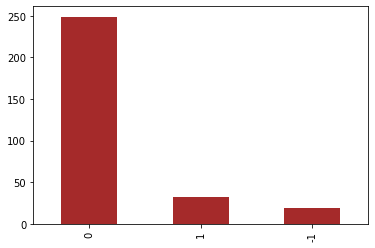

In [27]:
err.value_counts().plot(kind='bar',color='brown')

In [28]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.17
MSE: 0.17
RMSE: 0.41231056256176607


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[114  32]
 [ 19 135]]
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       146
           1       0.81      0.88      0.84       154

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



In [30]:
import pickle
# open a file, where you ant to store the data
file = open('xgboost_diabetes.pkl', 'wb')
# dump information to that file
pickle.dump(best_model, file)
file.close()